In [74]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt

#### Wczytanie danych

In [3]:
dataframe = pd.read_csv('resources/datasets/sp_retro/discretized.csv', na_values=('?',))

In [4]:
dataframe.head()

,NUMBER,AGE,HX_AS,NAUSEA,VOMIT,NAUSEA_OR_VOMIT,ABD_PAIN,ONSET,PAIN_TYPE,DURATION,...,SITE_SWELLING,COLOR,TEST_LIE,CORD_PALP,CREM_REF,TRANSILLUM,URINE_WBC,URINE_BACT,URINE_RBC,TRIAGE
0,1,LT10Y,NaN,NaN,NO,NONE,YES,NaN,NaN,LT6H,...,OSC,NaN,NaN,ABNORMAL,NaN,NaN,NaN,NaN,NaN,CLINIC
1,2,GE10Y_LE13Y,NaN,NaN,NaN,NaN,YES,SUDDEN,NaN,GE6H_LE24H,...,OSC,ERYTHEMA,NORMAL,NORMAL,YES,YES,NEG_0_5,NEG,NEG_0_5,CLINIC
2,3,GT13Y,NO,YES,YES,VOMIT,NaN,SUDDEN,NaN,GE6H_LE24H,...,TESTICLE,NORMAL,NaN,NaN,NaN,NaN,NEG_0_5,POS,NEG_0_5,CONSULT
3,4,GT13Y,NaN,NaN,YES,VOMIT,YES,NaN,CONSTANT,GT24H,...,NONE,ERYTHEMA,NaN,NORMAL,NaN,NaN,NEG_0_5,NaN,NEG_0_5,DISCHARGE
4,5,LT10Y,NaN,NaN,NO,NONE,YES,GRADUAL,NaN,LT6H,...,NONE,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DISCHARGE


<Axes: xlabel='TRIAGE', ylabel='count'>

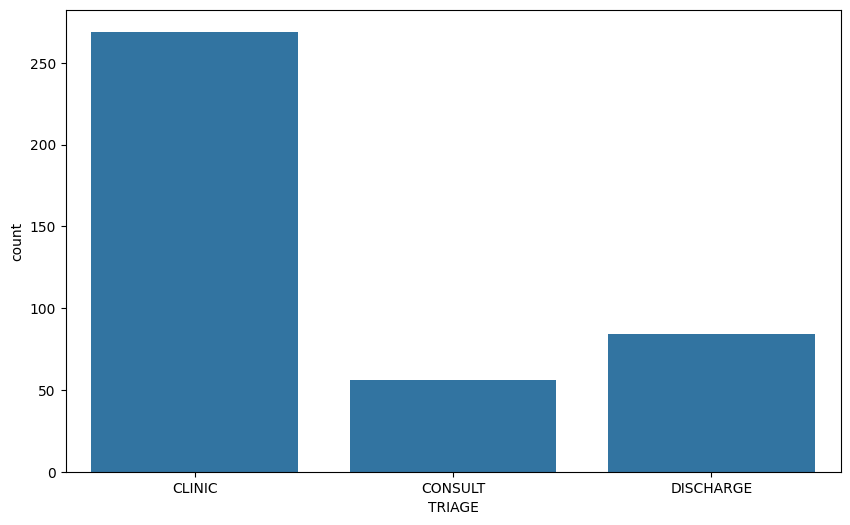

In [5]:
sns.countplot(x=dataframe.TRIAGE, data=dataframe)

#### Binaryzacja klasy decyzyjnej

<Axes: xlabel='TRIAGE', ylabel='count'>

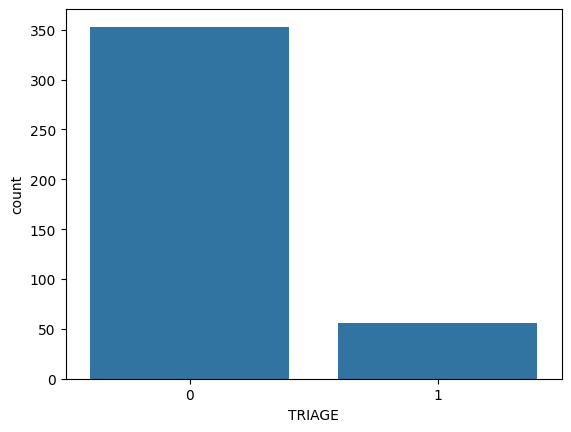

In [16]:
X = dataframe.drop(columns=['TRIAGE'])
X = pd.get_dummies(X)
X = X.to_numpy()
y = (dataframe.TRIAGE == "CONSULT").astype(int).to_numpy()


y_df = pd.DataFrame((dataframe.TRIAGE == "CONSULT").astype(int))
sns.countplot(x=y_df.TRIAGE, data=y_df)

#### Ocena klasyfikatora za pomocą 5-krotnej warstwowej walidacji krzyżowej (stratified crossvalidation) powtórzonej 3-krotnie 

In [181]:
# Compute area under the precision-recall curve, not receiver operating characteristic curve.
def calc_auprc(y, y_pred): 
    precision, recall, _ = metrics.precision_recall_curve(y, y_pred)
    # metrics.auc(x,y) - compute Area Under the Curve (AUC). This is a general function, given points on a curve.
    return metrics.auc(recall, precision)

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
def calc_auroc(y, pred):
    return metrics.roc_auc_score(y, pred)

def calc_sensitivity(y_true, y_predicted):
    true_positives = sum((y_true == 1) & (y_predicted == 1))
    false_negatives = sum((y_true == 1) & (y_predicted == 0))
    
    if true_positives + false_negatives == 0:
        return 0  # to handle division by zero
    return true_positives / (true_positives + false_negatives)

def calc_specificity(y_true, y_predicted):
    true_negatives = sum((y_true == 0) & (y_predicted == 0))
    false_positives = sum((y_true == 0) & (y_predicted == 1))
    
    if true_negatives + false_positives == 0:
        return 0  # to handle division by zero
    
    return true_negatives / (true_negatives + false_positives)

# returns tuple[medium-risk, high-risk]
def calculate_tresholds(y_true, y_predicted):
    sensitivity = calc_sensitivity(y_true, y_predicted)
    specificity = calc_specificity(y_true, y_predicted)
    return sensitivity*0.99, specificity*0.9

def classify_responses(y_pred, medium_risk, high_risk):
    return np.array([
            0 if response < medium_risk else 1 if response >= high_risk else np.nan
            for response in y_pred
        ])

def calculate_fnr_tnr(y, y_pred):
    tn, tp, fn, fp = metrics.confusion_matrix(y, y_pred).ravel()
    fnr = fn / (tp + fn)
    tnr = tn / (tn + fp)  
    return fnr, tnr

def plot(results, title: str):
  format = lambda val: f'{val * 100:.2f}%'
  colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
  figure, axis = plt.subplots(3, 1, figsize=(8, 16), tight_layout=True)


  axis[0].bar(['FNR', 'TNR'], [results.fnr, results.tnr], color=colors)
  axis[0].set_title('FNR and FPR metrics')
  axis[0].set_ylabel('Rate')
  axis[0].set_xlabel('Rate Type')
  
  for i, value in enumerate([results.fnr, results.tnr]):
    axis[0].text(i, value, f'{value * 100:.2f}%', ha='center', va='bottom')

  axis[1].bar(['AUPRC', 'AUROC'], [results.auprc, results.auroc], color=colors )
  axis[1].set_title('Scores')
  axis[1].set_ylabel('Score')
  axis[1].set_xlabel('Score Type')
  for i, value in enumerate([results.auprc, results.auroc]):
    axis[1].text(i, value, f'{value * 100:.2f}%', ha='center', va='bottom')

  axis[2].bar(
    ['Negatives', 'Positives', 'Unknowns'],
    [results['negative'], results['positive'], results['unknown']],
    color=colors
  )
  axis[2].set_title('Classification Rates')
  axis[2].set_ylabel('Rate')
  axis[2].set_xlabel('Rate Type')
  axis[2].text(0, results.negative, format(results.negative), ha='center', va='bottom')
  axis[2].text(1, results.positive, format(results.positive), ha='center', va='bottom')
  axis[2].text(2, results.unknown, format(results.unknown), ha='center', va='bottom')

  figure.suptitle(title)
  figure.show()


In [182]:
def run_classifier(classfier, seed, n_splits, n_repeats):
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

    auprc, auroc = [], []
    fnr, tnr = [], []
    negatives, positives, unknowns = [], [], []
    results = []
    
    for i, (train_idx, test_idx) in enumerate(rskf.split(X, y)):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        n_samples = len(y_te)
        classfier.fit(X_tr, y_tr)

        # assert list(clf.classes_) == [0, 1]
        # Calculate tresholds 
        y_pred_tr = classfier.predict(X_tr)
        medium_risk, high_risk = calculate_tresholds(y_tr, y_pred_tr)

        # Predict labels on test set
        y_prob = classfier.predict_proba(X_te)[:,1]
        auprc = calc_auprc(y_te, y_prob) 
        auroc = calc_auroc(y_te, y_prob)
        y_pred = classify_responses(y_prob, medium_risk, high_risk)

        # Calculate metrics
        positive = np.sum(y_pred == 1)
        negative = np.sum(y_pred == 0)
        unknown = np.sum(np.isnan(y_pred))

        mask = ~np.isnan(y_pred) #remove nans
        y_pred_th = y_pred[mask]
        y_te_th = y_te[mask]

        fnr, tnr = calculate_fnr_tnr(y_te_th, y_pred_th)
        res = dict(auprc=auprc, auroc=auroc, fnr=fnr, tnr=tnr, positive=positive/n_samples, negative=negative/n_samples, unknown=unknown/n_samples)
        print(res)
        results.append(res)
    
    return results

In [183]:
# Ziarno losowania 
SEED = 42
N_SPLITS = 5
N_REPEATS = 3

{'auprc': 0.45738184559178363, 'auroc': 0.7861715749039694, 'fnr': 1.0, 'tnr': 0.9696969696969697, 'positive': 0.024390243902439025, 'negative': 0.8780487804878049, 'unknown': 0.0975609756097561}
{'auprc': 0.5319176250092926, 'auroc': 0.8040973111395646, 'fnr': 1.0, 'tnr': 1.0, 'positive': 0.0, 'negative': 0.9390243902439024, 'unknown': 0.06097560975609756}
{'auprc': 0.4074284096402978, 'auroc': 0.7477592829705506, 'fnr': 1.0, 'tnr': 1.0, 'positive': 0.0, 'negative': 0.9512195121951219, 'unknown': 0.04878048780487805}
{'auprc': 0.7283027021997611, 'auroc': 0.9178571428571428, 'fnr': 1.0, 'tnr': 0.9857142857142858, 'positive': 0.012195121951219513, 'negative': 0.926829268292683, 'unknown': 0.06097560975609756}
{'auprc': 0.5584826962544278, 'auroc': 0.742857142857143, 'fnr': 1.0, 'tnr': 0.9857142857142858, 'positive': 0.012345679012345678, 'negative': 0.9382716049382716, 'unknown': 0.04938271604938271}
{'auprc': 0.38872468666260235, 'auroc': 0.8553137003841229, 'fnr': 0.875, 'tnr': 0.985

C:\Users\milos\AppData\Local\Temp\ipykernel_14168\1917661718.py:80: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


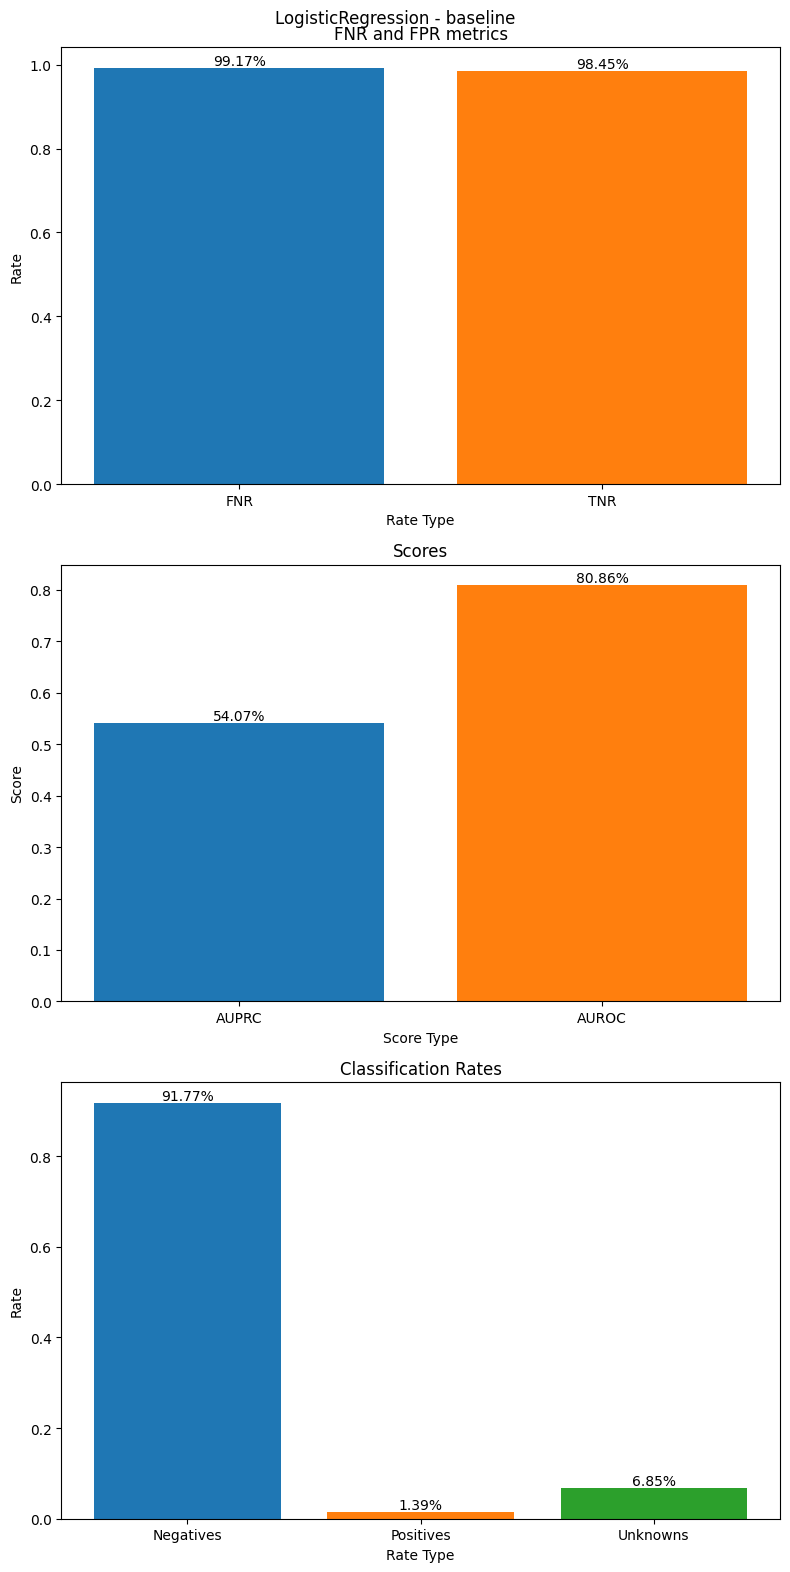

In [187]:
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer

clf = LogisticRegression(random_state=SEED)
clf2 = Pipeline([("imputer", SimpleImputer()), ("clf", LogisticRegression(max_iter=10000))])
results = run_classifier(clf2, seed=SEED, n_splits=N_SPLITS, n_repeats=N_REPEATS)

df = pd.DataFrame(results).mean()
print(df.head())
plot(df, "LogisticRegression - baseline")
